# Goals

Modeling the time it takes to close issues, and eventually a deeper analysis the relationship between time it takes to close, and the types of issues that exist.

In [1]:
# Import useful packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./Improve_Detroit_Issues.csv', header = 0)
data.head()

C:\Users\Victor Le\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,X,Y,id,status,request_type_title,description,web_url,report_method,priority_code,created_at,...,closed_at,reopened_at,updated_at,days_to_close,canonical_issue_id,address,neighborhood,council_district,oid,geom
0,-82.922541,42.399903,9630294,Acknowledged,Investigate Blocked Basin Street,storm water backflow into my basement,https://seeclickfix.com/issues/9630294,direct,2,2021/04/01 06:05:38+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 06:05:45+00,NaN,NaN,"3981 Guilford St Detroit, MI 48224, USA",NaN,NaN,1,NaN
1,-83.232881,42.333398,9629814,Acknowledged,Investigate Blocked Basin Street,Sewer Water has been pouring into my basement ...,https://seeclickfix.com/issues/9629814,direct,2,2021/04/01 04:50:04+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:50:28+00,NaN,NaN,"6073 Auburn St Detroit MI 48228, United States",NaN,NaN,2,NaN
2,-83.107571,42.436438,9629750,Open,Traffic Complaints,Person lighting fireworks and loud explosives ...,https://seeclickfix.com/issues/9629750,direct,2,2021/04/01 04:20:51+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:20:51+00,NaN,NaN,"400 Annin St Detroit MI 48203, United States",NaN,NaN,3,NaN
3,NaN,NaN,9629710,Open,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/9629710,direct,2,2021/04/01 04:00:45+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:00:47+00,NaN,NaN,Redacted,NaN,NaN,4,NaN
4,-83.223464,42.346134,9629705,Open,Reboard House Request,This home is burnt down. Dumping is starting ...,https://seeclickfix.com/issues/9629705,direct,2,2021/04/01 03:58:55+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 03:59:01+00,NaN,NaN,"7395 Brace St Detroit, MI 48228, USA",NaN,NaN,5,NaN


# Exploration of time it takes to close issues

## Let's look at how long it takes to close an issue by the month

In [3]:
# There's already a column documenting the time it took to close the issue. However there are a lot of nulls values.
month = pd.to_datetime(data['created_at']) # convert to a datetime object
month = month.apply(lambda x: x.month) # apply and grab the integer representing the month. 

monthClose = pd.concat([month, data['days_to_close']], axis = 1)
monthClose.rename(columns = {'created_at':'month'}, inplace=True)


### Plotting linear fit

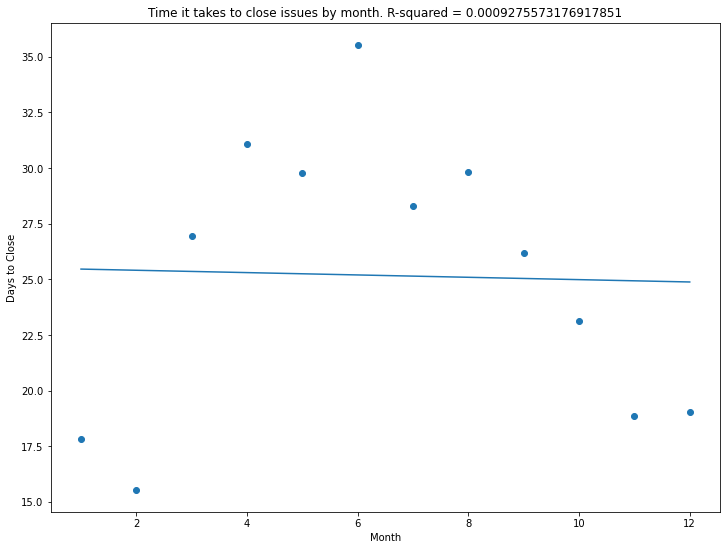

In [69]:
from sklearn.linear_model import LinearRegression

x = np.arange(1,13).reshape(-1,1)
y = monthClose.groupby('month').mean()

model = LinearRegression()
model.fit(x,y)
y_pred = model.coef_*x + model.intercept_

plt.figure(figsize = (12,9))
plt.scatter(x, y)
plt.plot(x, y_pred)
plt.ylabel('Days to Close')
plt.xlabel('Month')
plt.title('Time it takes to close issues by month. R-squared = {}'.format(model.score(x,y)))
plt.show()

Now that's interesting! There's obviously a quadratic relationship between the month, and the amount of days it takes to close the issue. A linear model is clearly not the right way to model this data.

### Plotting quadratic fit

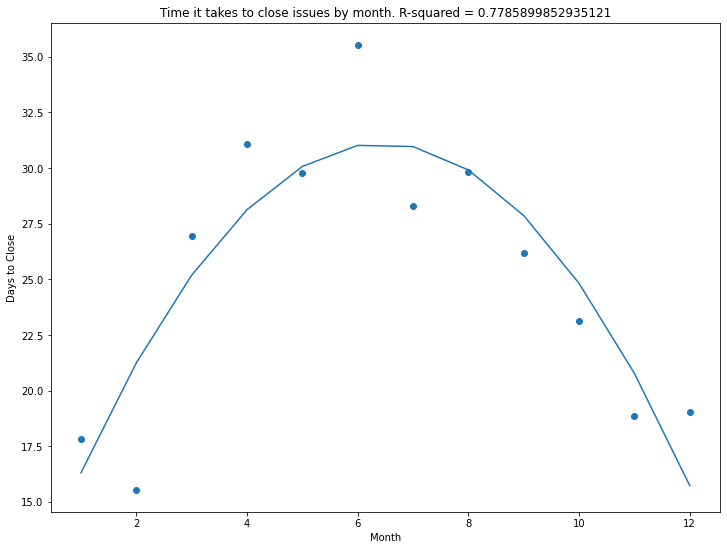

In [68]:
from sklearn.preprocessing import PolynomialFeatures

x = np.arange(1,13).reshape(-1,1)
x2 = x ** 2
x_quad = np.concatenate((x, x2), axis = 1)
x_quad.reshape(-1, 2)
y = monthClose.groupby('month').mean()

model = LinearRegression()
model.fit(x_quad,y)
y_pred = model.predict(x_quad)

plt.figure(figsize = (12,9))
plt.scatter(x, y)
plt.plot(x, y_pred)
plt.ylabel('Days to Close')
plt.xlabel('Month')
plt.title('Time it takes to close issues by month. R-squared = {}'.format(model.score(x_quad,y)))
plt.show()

Much better, and we're getting a pretty decent R-squared term as well. Evidently, there's a concave down relationship between month and time it takes to close issues. This seems counterintuitive, as it feels like holiday months (later in the Fall and early Winter) would be when it takes issues longest. However, it seems like the summer months take the absolute longest, with June take even more than a month to close. 

Yet, this does not tell the full story, as the amount of time it takes to close may very well depend on the types of issues that show up during the year. The next step is to figure out what kinds of issues appear during which months.

# Distribution of Issues by Month

In [132]:
issueMonth = pd.concat([data['request_type_title'], month], axis = 1)
issueMonth_df = issueMonth.groupby(['created_at', 'request_type_title']).size()

# need to clear issues that involve DPW 
issueTypes = list(issueMonth_df.loc[1].index)
DPW_issues = [x for x in issueTypes if 'DPW' in x ]
issueMonth_df.drop(index = DPW_issues, level = 1, inplace = True)
issueMonth_df.groupby(['created_at'], group_keys = False).nlargest(3).unstack()

request_type_title,Abandoned Vehicle,Curbside Solid Waste Issue,Illegal Dump Sites,Potholes,Residential Snow Removal Issue
created_at,,,,,
1,3206.0,3111.0,3375.0,NaN,NaN
2,3227.0,3030.0,NaN,NaN,2895.0
3,3950.0,6539.0,5829.0,NaN,NaN
4,NaN,4174.0,6186.0,3683.0,NaN
5,3613.0,4351.0,6774.0,NaN,NaN
6,3862.0,4650.0,7161.0,NaN,NaN
7,4221.0,4687.0,8113.0,NaN,NaN
8,4685.0,4457.0,7358.0,NaN,NaN
9,3897.0,4100.0,6336.0,NaN,NaN


Looking at the top 3 issues per month (that's not issued by the public works department), it seems like "Curbside Solid Waste", "Abandoned Vehicle", and "Illegal Dump Sites" are the most common throughout the year. Let's visualize how these change over the year. 

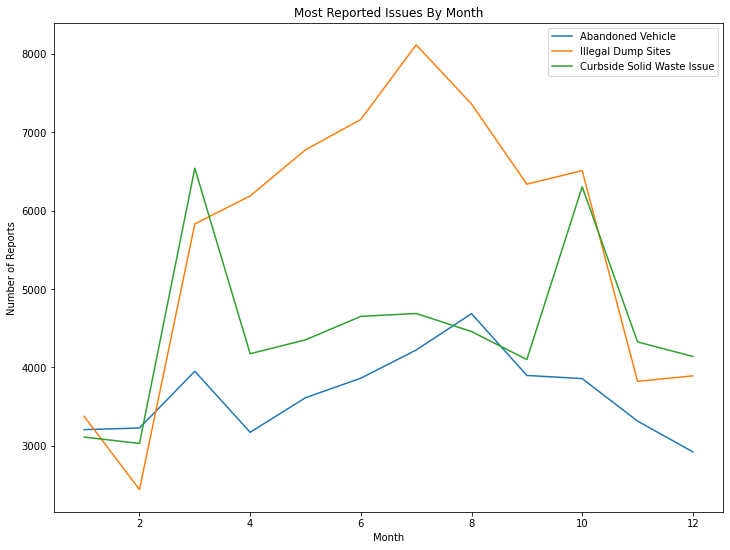

In [154]:
issueMonth_df = issueMonth.groupby(['created_at', 'request_type_title']).size()
issueMonth_df = issueMonth_df.unstack()

x = issueMonth_df.index
y1 = issueMonth_df['Abandoned Vehicle']
y2 = issueMonth_df['Illegal Dump Sites']
y3 = issueMonth_df['Curbside Solid Waste Issue']
figure = plt.figure(figsize = (12,9))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend(['Abandoned Vehicle', 'Illegal Dump Sites', 'Curbside Solid Waste Issue'])
plt.xlabel('Month')
plt.ylabel('Number of Reports')
plt.title('Most Reported Issues By Month')
plt.show()

Now that's a little interesting! Month to month, it seems like vehicles are abandoned quite consistently. Meanwhile, there is a very clear trend in the number of illegal dump sites, peaking in the middle of the year before dying down at the end of the year. This trend is probably what drives the concave curve we saw in the previous graph. This brings us to further question why illegal dump sites increased like this. In contrast, curbside solid waste issues are practically bimodal, with the most issues being reported during March and October. 